In [ ]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.9 MB/s 


In [ ]:
pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 4.7 MB/s 


In [ ]:
pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
import os
import time
from random import randint

from sklearn.ensemble import RandomForestRegressor

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


import albumentations as A
from albumentations import Compose, HorizontalFlip
from albumentations.pytorch.transforms import ToTensor, ToTensorV2 

import warnings
warnings.simplefilter("ignore")

In [ ]:
class GlobalConfigurations:
    root_dir = '/content/drive/MyDrive/FULL_BRATS_2020'
    train_root_dir = '/content/drive/MyDrive/FULL_BRATS_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = '/content/drive/MyDrive/FULL_BRATS_2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = '/content/drive/MyDrive/FULL_BRATS_2020/train_data.csv'
    seed = 55

survival_information_df = pd.read_csv('/content/drive/MyDrive/FULL_BRATS_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
mapping_name_df = pd.read_csv('/content/drive/MyDrive/FULL_BRATS_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

mapping_name_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


In [ ]:
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfigurations()
seed_everything(config.seed)

Creating csv file containing location of training and testing dataset to be used by Dataloader(ie. Data Generator).

In [ ]:
df = survival_information_df.merge(mapping_name_df, on="Brats20ID", how="right")

paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    
    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)
    
df['path'] = paths

train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

skf = StratifiedKFold(
    n_splits=30, random_state=config.seed, shuffle=True
)
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i

train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv("/content/drive/MyDrive/FULL_BRATS_2020/train_data.csv", index=False)

train_df -> (227, 12) val_df -> (8, 12) test_df -> (133, 10)


Defenations of the different funtions to be used in completing Task 2.

-get_dataloader :-returns a function that is identical to data generator which feeds training data to the model in training.

-get_augmentation: returns a list of augmentation that is to be performed on the dataset.

-Class Autoencoder:-Contains the main autoencoder model for the task 2

-Class Trainer:- Contains the pytorch configs for training of the model and facilitating the training of the autoencoder. 


In [ ]:
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    number_workers: int = 4,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        number_workers=number_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return data_loader

def get_augmentations(phase):
    augmentation_list = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),]
    
    list_transformation = Compose(augmentation_list)
    return list_transformation


class AutoEncoderDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = "test"):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            image_path = os.path.join(root_path, id_ + data_type)
            image = self.load_image(image_path)

            image = self.normalize(image)
            images.append(image.astype(np.float32))
        image = np.stack(images)
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
    
        
        return {
            "Id": id_,
            "data": image,
            "label": image,
            }
    
    def load_image(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray,  mean=0.0, std=1.0):
        """Normilize image value between 0 and 1."""
        data_minimum = np.min(data)
        return (data - data_minimum) / (np.max(data) - data_minimum)



class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(4, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        # self.conv4 = nn.Conv3d(64, 128, 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.enc_linear = nn.Linear(381216, 512)
        
        # Decoder
        # self.deconv1 = nn.ConvTranspose3d(128, 64, 2)
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 4, 3)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

        self.dec_linear = nn.Linear(512, 381216)
        
    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, indices1 = self.pool1(x)
        x = self.conv2(x)
        up2out_shape = x.shape
        x, indices2 = self.pool2(x)
        x = self.conv3(x)
        up1out_shape = x.shape
        x, indices3 = self.pool3(x)
        #print(x.shape)
        x = x.view((x.size(0), -1))
        #print(x.shape)
        x = self.enc_linear(x)
        #print(x.shape)
        # required for unpool
        pool_par = {
            "P1": [indices1, up3out_shape], 
            "P2": [indices2, up2out_shape], 
            "P3": [indices3, up1out_shape]
                   }
        
        if return_partials:
            return x, pool_par
        else:
            return x

    def decode(self, x, pool_par):
        x = self.dec_linear(x)
        x = x.view((x.size(0), 96, 11, 19, 19))
        
        x = self.unpool1(x, output_size=pool_par["P3"][1], indices=pool_par["P3"][0])
        #print(x.shape)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=pool_par["P2"][1], indices=pool_par["P2"][0])
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=pool_par["P1"][1], indices=pool_par["P1"][0])
        x = self.deconv3(x)
        return x
    
    def forward(self, x):
        self.feature, pool_par = self.encode(x)
        out = self.decode(self.feature, pool_par)
        return out

class Trainer:
    def __init__(self,
                 net: nn.Module,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 dataset: torch.utils.data.Dataset,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {

            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                number_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
         
    def compute_loss_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['data'], data_batch['label']
            loss, logits = self.compute_loss_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches

        
        self.losses[phase].append(epoch_loss)
        print(f"Loss | {self.losses[phase][-1]}")


        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self.do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self.do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "/content/drive/MyDrive/FULL_BRATS_2020/autoencoder_best_model.pth")
            print()
        self._save_train_history()
            
        
    def _save_train_history(self):
        torch.save(self.net.state_dict(),
                   f"/content/drive/MyDrive/FULL_BRATS_2020/autoencoder_last_epoch_model.pth")

Loading the data_loader with training paths of the training dataset.

In [ ]:
data_loader = get_dataloader(AutoEncoderDataset, '/content/drive/MyDrive/FULL_BRATS_2020/train_data.csv', phase='valid', fold=0)
len(data_loader)

data = next(iter(data_loader))
data['Id'], data['data'].shape, data['label'].shape

(['BraTS20_Training_120'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 4, 155, 240, 240]))

Training the model

In [ ]:
model = AutoEncoder().to('cuda')

trainer = Trainer(net=model,
                  dataset= AutoEncoderDataset,
                  criterion=MSELoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=3,
                  num_epochs=10,
                  path_to_csv = config.path_to_csv,)

trainer.run()

device: cuda
train epoch: 0 | time: 19:55:40
Loss | 0.015015756266216217
val epoch: 0 | time: 20:00:32
Loss | 0.007399354421067983

####################
Saved new checkpoint
####################


train epoch: 1 | time: 20:01:04
Loss | 0.006086742351578327
val epoch: 1 | time: 20:03:45
Loss | 0.0056798941805027425

####################
Saved new checkpoint
####################


train epoch: 2 | time: 20:03:59
Loss | 0.0049131593876210605
val epoch: 2 | time: 20:06:36
Loss | 0.005003719183150679

####################
Saved new checkpoint
####################


train epoch: 3 | time: 20:06:50
Loss | 0.004342771969153033
val epoch: 3 | time: 20:09:31
Loss | 0.004585377697367221

####################
Saved new checkpoint
####################


train epoch: 4 | time: 20:09:45
Loss | 0.004051353715232979
val epoch: 4 | time: 20:12:25
Loss | 0.004366456269053742

####################
Saved new checkpoint
####################


train epoch: 5 | time: 20:12:39
Loss | 0.0038280635646499267
val 

Evaluating the model

In [ ]:
data_loader = get_dataloader(AutoEncoderDataset, '/content/drive/MyDrive/FULL_BRATS_2020/train_data.csv', phase='val', fold=0)
model.eval();
with torch.no_grad():
    for data in dataloader:
        id_, imgs, targets = data['Id'], data['data'], data['label']
        imgs, targets = imgs.to('cuda'), targets.to('cuda')
        output = model(imgs)
        output = output.cpu()
        break

Generating feautures with the help of feature generator class

In [ ]:
class Features_Generator:
    
    def __init__(self, df, autoencoder):
        self.df = df
        self.df_voxel_stats = pd.DataFrame()
        self.latent_feature_generator = LatentFeaturesGenerator(autoencoder)
        
    def read_file(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj).astype(np.float32)
        return data
    
    def _normalize(self, data: np.ndarray):
        data_minimum = np.min(data)
        return (data - data_minimum) / (np.max(data) - data_minimum)
    
    def create_features(self, Brats20ID):
        features = {}
        images = []
        # vOXEL STATS
        for data_type in ['_t1.nii', '_t2.nii', '_flair.nii', '_t1ce.nii']:
            
            
            # data path
            root_path = self.df.loc[self.df['Brats20ID'] == Brats20ID]['path'].values[0]
            file_path = os.path.join(root_path, Brats20ID + data_type)
            
            # flatten 3d array
            image_data = self.read_file(file_path)
            data = image_data.reshape(-1)
            
            # create features
            data_mean = data.mean()
            data_std = data.std()
            intensive_data = data[data > data_mean]
            more_intensive_data = data[data > data_mean + data_std]
            non_intensive_data = data[data < data_mean]
            
            skew_data = stats.skew(data)
            kurtosis_data = stats.kurtosis(data)
            intensive_skew = stats.skew(intensive_data)
            non_intensive_skew = stats.skew(non_intensive_data)
            
            data_diff = np.diff(data)
            
            # write new features in df
            features['Brats20ID'] = Brats20ID
            features[f'{data_type}_skew'] = skew_data,
            features[f'{data_type}_kurtosis'] = kurtosis_data,
            features[f'{data_type}_diff_skew'] = stats.skew(data_diff),
            features[f'{data_type}_intensive_dist'] = intensive_data.shape[0],
            features[f'{data_type}_intensive_skew'] = intensive_skew,
            features[f'{data_type}_non_intensive_dist'] = non_intensive_data.shape[0],
            features[f'{data_type}_non_intensive_skew'] = non_intensive_skew,
            features[f'{data_type}_data_intensive_skew_difference'] = skew_data - intensive_skew,
            features[f'{data_type}_data_non_intensive_skew_difference'] = skew_data - non_intensive_skew,
            features[f'{data_type}_more_intensive_dist'] = more_intensive_data.shape[0],
            
            parts = 15
            for p, part in enumerate(np.array_split(data, parts)):
                features[f'{data_type}_part{p}_mean'] = part.mean()
                
            # Latent Features    
            image = self._normalize(image_data)
            images.append(image.astype(np.float32))
            
        image = np.stack(images)
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        latent_features = self.latent_feature_generator(image)
        
        for i, lf in enumerate(latent_features):
                features[f'latent_f{i}'] = lf
          
        return pd.DataFrame(features)
    
    
    def run(self):
        
        for _, row in tqdm(self.df.iterrows()):
            ID = row['Brats20ID']
            
            df_features = self.create_features(ID)
            
            self.df_voxel_stats  = pd.concat([self.df_voxel_stats, df_features], axis=0) 
            
        self.df_voxel_stats.reset_index(inplace=True, drop=True) 
        self.df_voxel_stats = self.df_voxel_stats.merge(self.df[['Brats20ID', 'Age', 'Survival_days']], on='Brats20ID', how='left')

class LatentFeaturesGenerator:
    def __init__(self, 
                 autoencoder, 
                 device: str = 'cuda'):
        
        self.autoencoder = autoencoder.to(device)
        self.device = device

    def __call__(self, image):
        with torch.no_grad():
            image = torch.FloatTensor(image).unsqueeze(0).to(self.device)
            latent_features = self.autoencoder.encode(
                image, return_partials=False).squeeze(0).cpu().numpy()

        return latent_features
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

Extracting the Featurs from the dataset

In [ ]:
%%time
model.eval();
fg =  Features_Generator(df, model)
fg.run()
fg.df_voxel_stats.to_csv("/content/drive/MyDrive/FULL_BRATS_2020/df_with_voxel_stats_and_latent_features.csv", index=False)
fg.df_voxel_stats

369it [20:11,  3.28s/it]


CPU times: user 11min 4s, sys: 1min 19s, total: 12min 24s
Wall time: 20min 11s


,Brats20ID,_t1.nii_skew,_t1.nii_kurtosis,_t1.nii_diff_skew,_t1.nii_intensive_dist,_t1.nii_intensive_skew,_t1.nii_non_intensive_dist,_t1.nii_non_intensive_skew,_t1.nii_data_intensive_skew_difference,_t1.nii_data_non_intensive_skew_difference,...,latent_f504,latent_f505,latent_f506,latent_f507,latent_f508,latent_f509,latent_f510,latent_f511,Age,Survival_days
0,BraTS20_Training_001,2.189104,3.143948,-0.302683,1342282,-0.410911,7585718,114.730570,2.600016,-112.541466,...,0.406362,-0.465786,0.108260,0.940693,-0.674111,0.699555,0.667672,-0.388187,60.463,289
1,BraTS20_Training_002,1.968389,2.200515,0.225981,1538803,-0.403005,7389197,143.749914,2.371394,-141.781525,...,1.057424,-0.019360,0.183432,0.772054,-0.781237,0.734150,1.461458,-0.395989,52.263,616
2,BraTS20_Training_003,2.297638,3.615512,1.908453,1261059,-0.654111,7666941,357.393259,2.951749,-355.095621,...,0.278366,-1.077500,0.174563,1.225469,-0.782288,0.771689,0.216374,-0.085515,54.301,464
3,BraTS20_Training_004,1.953941,2.127259,0.014855,1523029,-0.297262,7404971,292.762418,2.251202,-290.808478,...,1.043160,0.391338,0.335274,0.669449,-0.715342,0.695785,1.267796,-0.230359,39.068,788
4,BraTS20_Training_005,2.105768,2.791831,1.007016,1441603,-0.469777,7486397,192.826621,2.575545,-190.720853,...,0.398145,-0.240646,0.282970,0.572449,-0.724716,0.615901,0.592256,-0.303127,68.493,465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,BraTS20_Training_365,2.232847,3.353795,2.639713,1302376,-0.186473,7625624,0.000000,2.419320,2.232847,...,0.128511,0.200011,-0.152541,1.178675,-1.124837,0.718802,-0.202709,-0.025418,NaN,NaN
365,BraTS20_Training_366,2.503319,4.466538,-2.969314,1054761,-1.161960,7873239,1984.091243,3.665279,-1981.587924,...,0.012719,-2.793984,0.414452,1.531206,-0.739655,0.402933,0.309803,0.257211,72.000,633
366,BraTS20_Training_367,1.795406,1.509976,0.253106,1696109,-0.426782,7231891,1903.602113,2.222188,-1901.806707,...,0.882524,0.481654,0.289785,0.597069,-1.197008,0.354884,0.316459,-0.263209,60.000,437
367,BraTS20_Training_368,2.150280,2.922769,3.318562,1364050,-0.701650,7563950,192.933701,2.851929,-190.783421,...,0.337600,-0.669908,0.172897,1.024154,-0.790100,0.752230,0.278031,-0.279817,49.000,442


Loading the latent features generated earlier and definining the training data.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/FULL_BRATS_2020/df_with_voxel_stats_and_latent_features.csv")#

df['is_train'] = 0
df['is_train'].loc[df['Survival_days'].notnull()] = 1

df['SD'] = df['Survival_days'].str.extract(r'(\d+[.\d]*)')
df['SD'] = df['SD'].astype("float64")
df['Age'] = df['Age'].astype("float64")
df.sample(5)


,Brats20ID,_t1.nii_skew,_t1.nii_kurtosis,_t1.nii_diff_skew,_t1.nii_intensive_dist,_t1.nii_intensive_skew,_t1.nii_non_intensive_dist,_t1.nii_non_intensive_skew,_t1.nii_data_intensive_skew_difference,_t1.nii_data_non_intensive_skew_difference,...,latent_f506,latent_f507,latent_f508,latent_f509,latent_f510,latent_f511,Age,Survival_days,is_train,SD
242,BraTS20_Training_243,2.093595,2.790804,1.574525,1478065,-0.408143,7449935,81.883396,2.501738,-79.789801,...,-0.258638,-0.014078,-0.782359,0.636491,0.460786,-0.243577,NaN,NaN,0,NaN
67,BraTS20_Training_068,2.017991,2.406603,-0.978952,1493309,-0.434077,7434691,268.627413,2.452068,-266.609422,...,0.536191,0.691791,-0.866724,0.558515,0.677736,-0.398517,55.532,180,1,180.0
83,BraTS20_Training_084,2.008985,2.338470,1.322039,1485566,-0.568719,7442434,83.541632,2.577704,-81.532647,...,0.113797,0.457748,-0.631635,0.418841,0.602522,-0.091065,61.622,ALIVE (361 days later),1,361.0
118,BraTS20_Training_119,2.018468,2.382915,0.868472,1494098,-0.673546,7433902,38.323005,2.692015,-36.304536,...,0.264161,0.690171,-0.715712,0.532928,0.719551,-0.392654,45.575,524,1,524.0
30,BraTS20_Training_031,1.965990,2.293760,-0.634840,1608438,-0.188065,7319562,185.296154,2.154055,-183.330164,...,0.692808,0.431679,-0.941304,0.663053,0.711697,-0.354416,66.074,170,1,170.0


train -> (236, 617) test -> (133, 617)


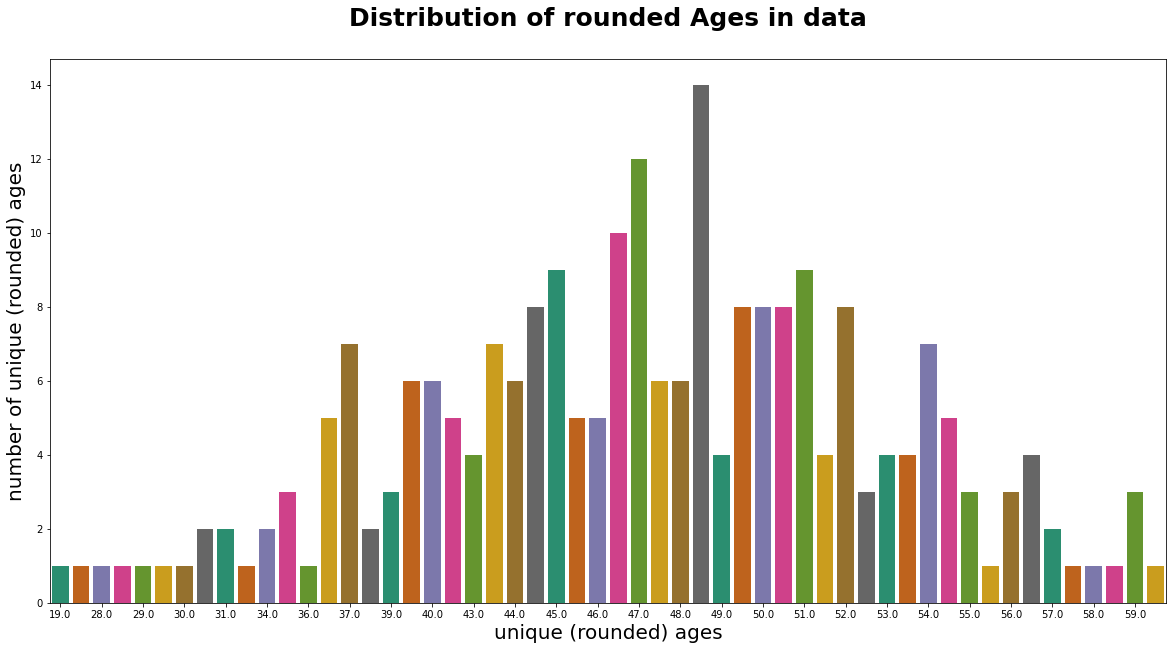

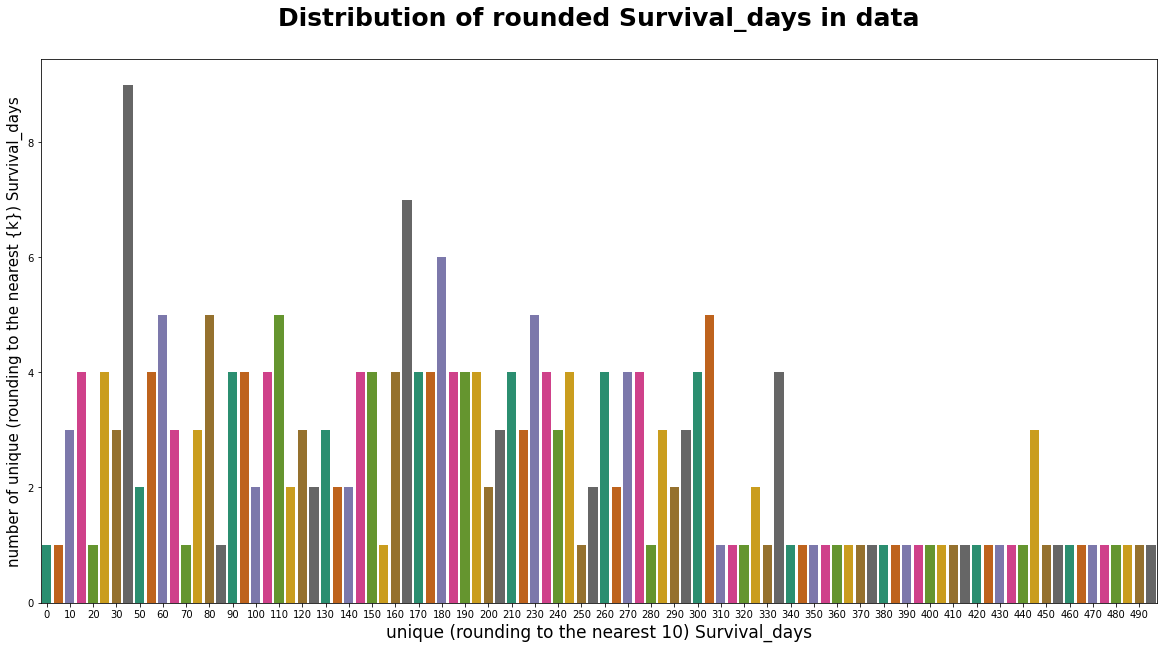

In [ ]:
test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()
print("train ->", df.shape, "test ->", test_df.shape)

fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(df['Age'].apply(lambda x: np.round(x, 0)), ax=ax, palette='Dark2')

ax.set_xticks(ax.get_xticks()[::2]);
ax.set_ylabel('number of unique (rounded) ages', fontsize=20)
ax.set_xlabel('unique (rounded) ages', fontsize=20)
ax.set_title("Distribution of rounded Ages in data", fontsize=25, y=1.05, fontweight='bold');
fig, ax = plt.subplots(figsize=(20, 10))
k = 10
sns.countplot(df['SD'].apply(lambda x: int(k * round(float(x)/k))), ax=ax, palette='Dark2')#base * round(float(x)/base)

ax.set_xticks(ax.get_xticks()[::2]);
ax.set_ylabel('number of unique (rounding to the nearest {k}) Survival_days', fontsize=15)
ax.set_xlabel(f'unique (rounding to the nearest {k}) Survival_days', fontsize=17)
ax.set_title("Distribution of rounded Survival_days in data", fontsize=25, y=1.05, fontweight='bold');

Getting the scores of our model

In [ ]:
%%time
NUM_FOLDS = 7
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=config.seed)


features = list(df.columns[1:-4])

overal_score = 0
for target,w in [("Age",0.5), ("SD",0.5)]:    
    y_true = np.zeros(df.shape[0])
    y_pred = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = RandomForestRegressor(max_depth=2,random_state=0)
        model.fit(train_df[features], train_df[target])

        y_true[val_ind] = model.predict(val_df[features])
        y_pred[:, f] = model.predict(test_df[features])
        
    df["pred_{}".format(target)] = y_true
    test_df[target] = y_pred.mean(axis=1)
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)
    overal_score += w*score
    print(target, np.round(score, 4))
    print()
    
print("Overal score:", np.round(overal_score, 4))

Age 0.0349

SD 0.5872

Overal score: 0.3111
CPU times: user 14.9 s, sys: 11 ms, total: 15 s
Wall time: 16.5 s
